In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

plt.rcParams["figure.figsize"] = (10,6)
# Suppress scientific notation in both Pandas and numpy
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df = sns.load_dataset('iris')

In [3]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10000,3.50000,1.40000,0.20000,setosa
1,4.90000,3.00000,1.40000,0.20000,setosa
2,4.70000,3.20000,1.30000,0.20000,setosa
3,4.60000,3.10000,1.50000,0.20000,setosa
4,5.00000,3.60000,1.40000,0.20000,setosa


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.00000,5.84333,0.82807,4.30000,5.10000,5.80000,6.40000,7.90000
sepal_width,150.00000,3.05733,0.43587,2.00000,2.80000,3.00000,3.30000,4.40000
petal_length,150.00000,3.75800,1.76530,1.00000,1.60000,4.35000,5.10000,6.90000
petal_width,150.00000,1.19933,0.76224,0.10000,0.30000,1.30000,1.80000,2.50000


In [6]:
df['species'].value_counts()

virginica     50
versicolor    50
setosa        50
Name: species, dtype: int64

In [7]:
df.duplicated().sum()

1

In [8]:
df[df.duplicated()]

,sepal_length,sepal_width,petal_length,petal_width,species
142,5.80000,2.70000,5.10000,1.90000,virginica


In [9]:
index = df[df.duplicated()].index
index

Int64Index([142], dtype='int64')

In [10]:
df=df.drop_duplicates(keep='first')

In [11]:
df.duplicated().sum()

0

In [12]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10000,3.50000,1.40000,0.20000,setosa
1,4.90000,3.00000,1.40000,0.20000,setosa
2,4.70000,3.20000,1.30000,0.20000,setosa
3,4.60000,3.10000,1.50000,0.20000,setosa
4,5.00000,3.60000,1.40000,0.20000,setosa
...,...,...,...,...,...
145,6.70000,3.00000,5.20000,2.30000,virginica
146,6.30000,2.50000,5.00000,1.90000,virginica
147,6.50000,3.00000,5.20000,2.00000,virginica
148,6.20000,3.40000,5.40000,2.30000,virginica


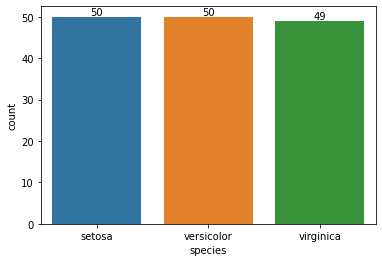

In [13]:
ax = sns.countplot(x=df['species'])
ax.bar_label(ax.containers[0]);

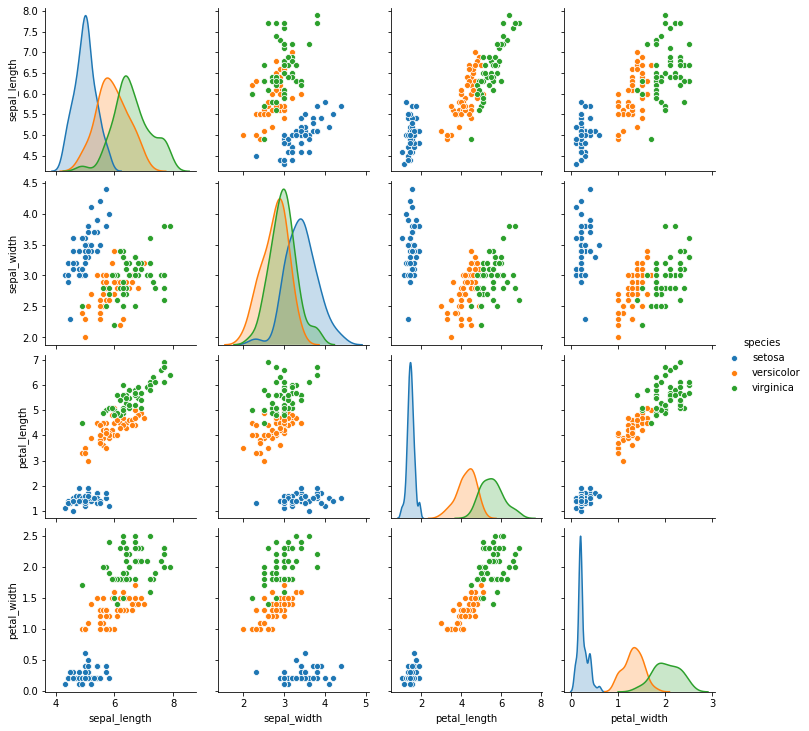

In [14]:
sns.pairplot(df, hue='species');

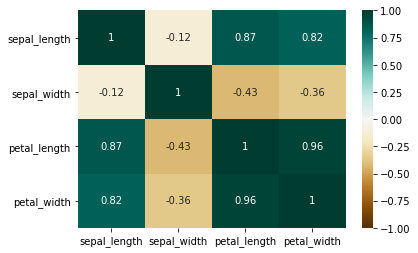

In [15]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='BrBG');

# Train | Test Split and Scaling

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



In [17]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [18]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def eval_metric_classification(model, X_train, y_train, X_test, y_test, model_name='', average=None, labels=None, ml_model=True):
   # The style parameters control properties like the color of the background and whether a grid is enabled by default.
    sns.set_style("whitegrid", {'axes.grid' : False})
    if ml_model:
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
    else:
        y_pred_test = model.predict(X_test) >= 0.5
        y_pred_train = model.predict(X_train) >= 0.5
    
    print("TEST REPORT")
    print(classification_report(y_test, y_pred_test))
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, ax=ax[0]);
    print("\n"*1, "-*"*30)
    print("TRAIN REPORT")
    print(classification_report(y_train, y_pred_train))
    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, ax=ax[1]);
    plt.tight_layout()
    
    return pd.DataFrame.from_dict({
        'accuracy_test' :accuracy_score(y_test, y_pred_test),
        'f1_test'       :np.array(f1_score(y_test, y_pred_test, average=average, labels=labels)).ravel()[0],
        'recall_test'   :np.array(recall_score(y_test, y_pred_test, average=average, labels=labels)).ravel()[0],
        'precision_test':np.array(precision_score(y_test, y_pred_test, average=average, labels=labels)).ravel()[0],        
        'accuracy_train' :accuracy_score(y_train, y_pred_train),
        'f1_train'       :np.array(f1_score(y_train, y_pred_train, average=average, labels=labels)).ravel()[0],        
        'recall_train'   :np.array(recall_score(y_train, y_pred_train, average=average, labels=labels)).ravel()[0],
        'precision_train':np.array(precision_score(y_train, y_pred_train, average=average, labels=labels)).ravel()[0],
    }, orient='index', columns=[model_name]).T

In [19]:
X = df.drop('species', axis=1)
y= df['species']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [21]:
random_state=101
scaler= StandardScaler()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)

In [23]:
from sklearn.preprocessing import LabelEncoder
lb_enc = LabelEncoder()

y_train = lb_enc.fit_transform(y_train)

y_test = lb_enc.transform(y_test)

# Logistic Regression

In [24]:
from sklearn.pipeline import Pipeline

log_model = LogisticRegression(random_state= random_state)

pipe_log = Pipeline([ ('scaler', scaler)
                      ,('log', log_model)
                   ])

pipe_log.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log', LogisticRegression(random_state=101))])

In [25]:
eval_metric(pipe_log, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 35  3]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.97      0.92      0.95        38
           2       0.93      0.97      0.95        40

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



## Cross Validate

In [26]:
from sklearn.model_selection import cross_validate

log_model = LogisticRegression(random_state= random_state)

model = Pipeline([ ('scaler', scaler)
                      ,('log', log_model)
                   ])

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision_macro','recall_macro',
                                                                   'f1_macro'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy           0.94924
train_accuracy          0.96451
test_precision_macro    0.96000
train_precision_macro   0.96481
test_recall_macro       0.94722
train_recall_macro      0.96359
test_f1_macro           0.94730
train_f1_macro          0.96384
dtype: float64

## GridSearchCV

In [27]:
from sklearn.model_selection import GridSearchCV


log_model = LogisticRegression(max_iter= 5000, random_state= random_state)

model = Pipeline([ ('scaler', scaler)
                      ,('log', log_model)
                   ])

param_grid = {
    "log__penalty" : ['l1'],
    "log__C" : [0.01, 0.1, 1, 5, 16, 19, 22, 25],
    "log__solver" : ['liblinear', 'saga']
}

grid_model = GridSearchCV(
    estimator = model,
    param_grid = param_grid, 
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
) 


In [28]:
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=101))]),
             n_jobs=-1,
             param_grid={'log__C': [0.01, 0.1, 1, 5, 16, 19, 22, 25],
                         'log__penalty': ['l1'],
                         'log__solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [29]:
grid_model.best_params_

{'log__C': 16, 'log__penalty': 'l1', 'log__solver': 'saga'}

In [30]:
grid_model.best_score_

0.9746376811594203

In [31]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 37  1]
 [ 0  0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      0.97      0.99        38
           2       0.98      1.00      0.99        40

    accuracy                           0.99       119
   macro avg       0.99      0.99      0.99       119
weighted avg       0.99      0.99      0.99       119



In [32]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test);

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [ ]:
import scikitplot as skplt

y_prob_test = grid_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_prob_test, title= 'ROC Curves for Logistic Regression')

plt.show()

In [ ]:
y_prob_test = grid_model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_prob_test, title= 'Precision-Recall Curve for Logistic Regression')
plt.show()

In [ ]:
out_score_log = eval_metric_classification(
    grid_model, X_train, y_train, X_test, y_test, 
    'Logistic Regression', average='macro', labels=None
)
out_score_log

# KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier


In [37]:
knn_model = KNeighborsClassifier(n_neighbors=5) 

pipe_knn = Pipeline([ ('scaler', scaler)
                      ,('knn', knn_model)
                   ])

pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [38]:
ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test);

AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_estimator'

In [39]:
eval_metric(pipe_knn, X_train, y_train, X_test, y_test)

Test_Set
[[ 8  1  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.86      1.00      0.92        12
           2       1.00      0.89      0.94         9

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.94        30
weighted avg       0.94      0.93      0.93        30


Train_Set
[[41  0  0]
 [ 0 36  2]
 [ 0  3 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.92      0.95      0.94        38
           2       0.95      0.93      0.94        40

    accuracy                           0.96       119
   macro avg       0.96      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119



## Cross Validate

In [40]:
from sklearn.model_selection import cross_validate, cross_val_score

knn_model = KNeighborsClassifier(n_neighbors=5) 
model = Pipeline([ ('scaler', scaler)
                      ,('knn', knn_model)
                   ])
 
scores = cross_validate(
    model, X_train, y_train, 
    scoring = ['precision_macro','recall_macro', 'f1_macro', 'accuracy'], 
    cv=10,
)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_precision_macro   0.94889
test_recall_macro      0.93056
test_f1_macro          0.92952
test_accuracy          0.93258
dtype: float64

## Elbow Method for Choosing Reasonable K Values

In [41]:
K = range(2,20)

# find error rates
test_error_rates = []
test_error_ratescv = []

for k in K: 
    knn_model = KNeighborsClassifier(n_neighbors=k) 
    # pipeline for KNeighbors Classifier regression
    pipe_knn = Pipeline([
                        ('scaler', scaler),
                        ("knn", knn_model)
    ]) 
    pipe_knn.fit(X_train , y_train) 
    y_pred_test = pipe_knn.predict(X_test)
    # Find the error from the test set
    test_error = 1 - accuracy_score(y_test, y_pred_test)  
    test_error_rates.append(test_error)
    
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # pipeline for Cross Validate
    model = Pipeline([('scaler', scaler)
                      ,("knn", knn_model)
                     ])  
    
    scoring = ['precision_macro','recall_macro', 'f1_macro', 'accuracy']

    scores = cross_validate(
        model, X_train, y_train, 
        scoring = scoring, 
        n_jobs=-1,
        cv = 10,
    )

    test_error = 1 - accuracy_score(y_test,y_pred_test) 
    test_error_ratescv.append(test_error)

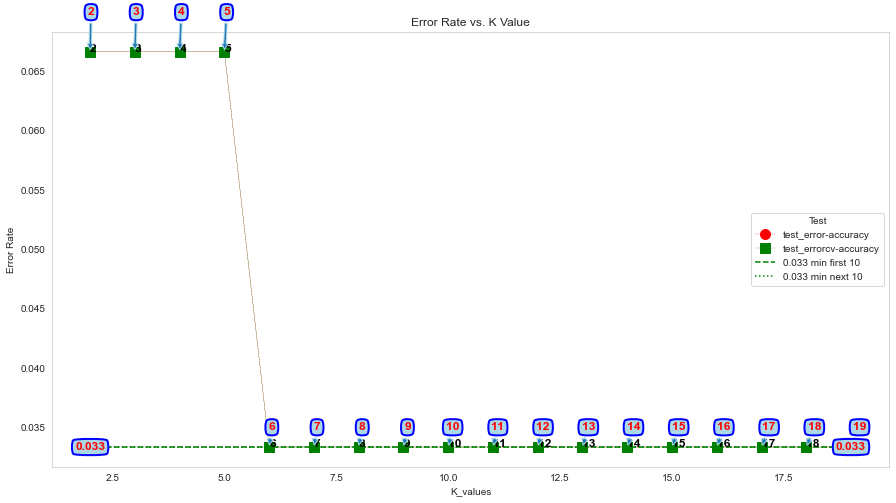

In [42]:
# plot        
plt.figure(figsize=(15,8))

plt.plot(
    K, test_error_rates, 
    color='r', ls='--', lw=0.3, 
    marker='o',mfc='r', ms=10,
    label='test_error-accuracy',
)
for k, err in zip(K, test_error_rates):
    plt.annotate(k, (k, err), size=12, color='k', weight='heavy') 
    
plt.plot(
    K, test_error_ratescv, 
    color='g', ls='--', lw=0.3,
    marker='s',mfc='g', ms=10,
    label='test_errorcv-accuracy',
)
for k, err in zip(K, test_error_ratescv):
    plt.annotate(
        text=f'{k:.0f}', 
        xy=(k, err), xycoords='data', 
        xytext=(k+(k*0.01), err+(err*0.05)), textcoords='data', 
        bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
        arrowprops=dict(arrowstyle="simple",
                        connectionstyle="arc3", ec="lightblue", lw=1),
        weight='heavy', color='r', size=12,
        ha='center', va='center'
    )

plt.text(
    x=min(K), y=min(test_error_ratescv[2:9]), 
    s=f'{min(test_error_ratescv[2:9]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='r', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(y=min(test_error_ratescv[2:10]), label=f'{min(test_error_ratescv[2:10]).round(3)} min first 10',
    xmin=min(K), xmax=max(K), colors='g', ls="--", 
)
plt.text(
    x=max(K), y=min(test_error_ratescv[9:19]), 
    s=f'{min(test_error_ratescv[9:19]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='r', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(min(test_error_ratescv[9:19]), label=f'{min(test_error_ratescv[9:19]).round(3)} min next 10',
    xmin=min(K), xmax=max(K), colors='g', ls=":", 
)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.legend(loc='center right', title='Test');

## Overfitting and underfitting control for k values

In [43]:
def elbow_method(K):
    test_error_rates = []
    train_error_rates = []

    for k in K: 
        knn_model = KNeighborsClassifier(n_neighbors=k)
        # pipeline for KNeighbors Classifier regression
        pipe_knn = Pipeline([
            
            ('scaler', scaler),
            ("knn", knn_model)
        ]) 
        pipe_knn.fit(X_train , y_train)
        y_pred_test = pipe_knn.predict(X_test)
        y_pred_train = pipe_knn.predict(X_train)
        
        
        test_error = 1-accuracy_score(y_test, y_pred_test)  
        train_error = 1-accuracy_score(y_train, y_pred_train)
        test_error_rates.append(test_error)
        train_error_rates.append(train_error)
        
    return test_error_rates, train_error_rates

test_error_rates, train_error_rates = elbow_method(K)

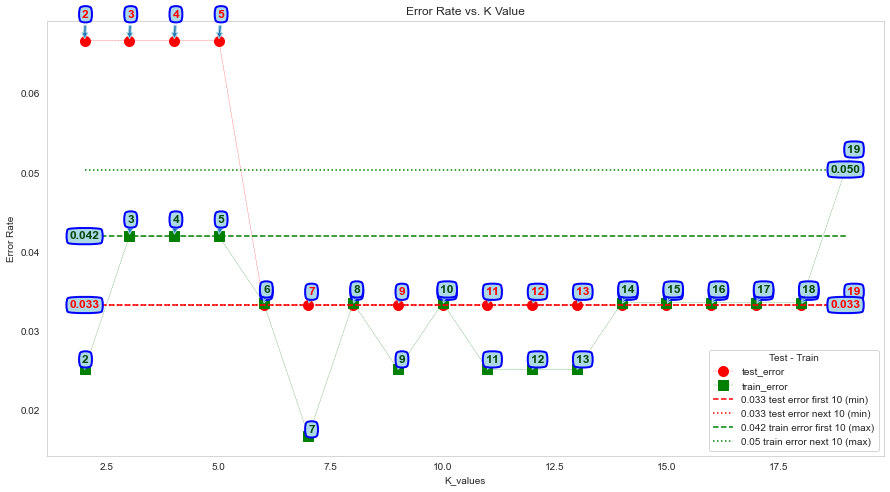

In [44]:
# plot 
plt.figure(figsize=(15,8))
plt.plot(
    K, test_error_rates, 
    color='r', ls='--', lw=0.3, 
    marker='o', mfc='r', ms=10,
    label='test_error',
)      
for k, err in zip(K, test_error_rates):
    plt.annotate(
        text=f'{k:.0f}', 
        xy=(k, err), xycoords='data', 
        xytext=(k+(k*0.01), err+(err*0.05)), textcoords='data', 
        bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
        arrowprops=dict(arrowstyle="simple",
                        connectionstyle="arc3", ec="lightblue", lw=1),
        weight='heavy', color='r', size=12,
        ha='center', va='center'
    )
    
plt.plot(
    K, train_error_rates, 
    color='g', ls='--', lw=0.3,
    marker='s', mfc='g', ms=10,
    label='train_error',
)     
for k, err in zip(K, train_error_rates):
   
    plt.annotate(
        text=f'{k:.0f}', 
        xy=(k, err), xycoords='data', 
        xytext=(k+(k*0.01), err+(err*0.05)), textcoords='data', 
        bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
        arrowprops=dict(arrowstyle="simple",
                        connectionstyle="arc3", ec="lightblue", lw=1),
        weight='heavy', color='xkcd:forest green', size=12,
        ha='center', va='center'
    )
    
# test first 10 point, next 10
plt.text(
    x=min(K), y=min(test_error_rates[2:9]), 
    s=f'{min(test_error_rates[2:9]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='r', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(y=min(test_error_rates[2:9]), label=f'{min(test_error_rates[2:9]).round(3)} test error first 10 (min)',
    xmin=min(K), xmax=max(K), colors= 'r', linestyles="--", 
)
plt.text(
    x=max(K), y=min(test_error_rates[9:19]), 
    s=f'{min(test_error_rates[9:19]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='r', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(y=min(test_error_rates[9:19]), label=f'{min(test_error_rates[9:19]).round(3)} test error next 10 (min)',
    xmin=min(K), xmax=max(K), colors= 'r', linestyles=":", 
)
# train first 10 point, next 10
plt.text(
    x=min(K), y=max(train_error_rates[2:9]), 
    s=f'{max(train_error_rates[2:9]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='xkcd:forest green', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(y=max(train_error_rates[2:9]), label=f'{max(train_error_rates[2:9]).round(3)} train error first 10 (max)',
    xmin=min(K), xmax=max(K), colors= 'g', linestyles="--", 
)
plt.text(
    x=max(K), y=max(train_error_rates[9:19]), 
    s=f'{max(train_error_rates[9:19]).round(3):.3f}', 
    bbox=dict(boxstyle="round4", pad=0.3, fc="lightblue", ec="b", lw=2),
    weight='heavy', color='xkcd:forest green', fontsize=12,
    ha='center', va='center', rotation='horizontal',
)
plt.hlines(y=max(train_error_rates[9:19]), label=f'{max(train_error_rates[9:19]).round(3)} train error next 10 (max)',
    xmin=min(K), xmax=max(K), colors= 'g', linestyles=":", 
)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.legend(loc='lower right', title='Test - Train')
plt.show()

In [45]:
#### With Best Parameters (GridsearchCV)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

knn_model = KNeighborsClassifier() 
model = Pipeline([
                    ('scaler',scaler),
                    ("knn", knn_model)
                ]) 
param_grid = {
    'knn__n_neighbors': range(3,15),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski'],
    'knn__p': [1,2],

}
grid_model = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    scoring = 'accuracy', 
    n_jobs=-1,
    cv=5
) 

In [46]:
%%time
grid_model.fit(X_train, y_train)

CPU times: user 555 ms, sys: 33.9 ms, total: 589 ms
Wall time: 618 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['minkowski'],
                         'knn__n_neighbors': range(3, 15), 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [47]:
grid_model.best_params_

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 6,
 'knn__p': 1,
 'knn__weights': 'uniform'}

In [48]:
grid_model.best_score_

0.9583333333333333

In [49]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 37  1]
 [ 0  3 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.93      0.97      0.95        38
           2       0.97      0.93      0.95        40

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



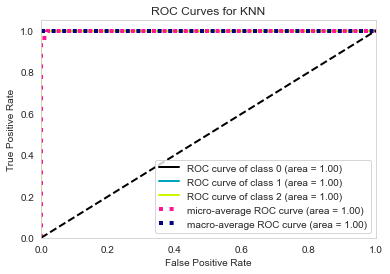

In [50]:
import scikitplot as skplt

y_prob_test = grid_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_prob_test, title='ROC Curves for KNN')
plt.show()

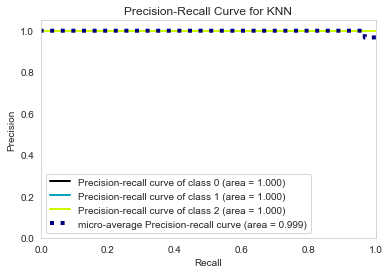

In [51]:
y_probas = grid_model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, title='Precision-Recall Curve for KNN' )
plt.show()

In [52]:

knn_model = KNeighborsClassifier(n_neighbors=6, p=1) 
model = Pipeline([
    ('scaler', scaler),
    ("knn", knn_model)
]) 
knn_model.fit(X_train,y_train)
print('WITH K=1\n')
eval_metric(knn_model, X_train, y_train, X_test, y_test)

WITH K=1

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 36  2]
 [ 0  3 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.92      0.95      0.94        38
           2       0.95      0.93      0.94        40

    accuracy                           0.96       119
   macro avg       0.96      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119



## Cross Validate for optimal k Value

In [53]:
from sklearn.model_selection import cross_validate, cross_val_score

knn_model = KNeighborsClassifier(n_neighbors=6, p=1) 
model = Pipeline([ ('scaler', scaler)
                      ,('knn', knn_model)
                   ])
 
scores = cross_validate(
    model, X_train, y_train, 
    scoring = ['precision_macro','recall_macro', 'f1_macro', 'accuracy'], # scoring, 
    cv=10,
)

df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_precision_macro   0.96667
test_recall_macro      0.95833
test_f1_macro          0.95767
test_accuracy          0.95833
dtype: float64

In [54]:
out_score_knn = eval_metric_classification(
    grid_model, X_train, y_train, X_test, y_test, 
    'KNN', average='macro', labels=None
)
out_score_knn

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

# SVM

In [ ]:
from sklearn.svm import SVC



svc_model = SVC(
    probability=True,
    random_state=random_state
)   
pipe_svc = Pipeline([
    ('scaler',scaler),
    ("svc", svc_model),
]) 
pipe_svc.fit(X_train , y_train)

In [56]:
eval_metric(pipe_svc, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 36  2]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.97      0.95      0.96        38
           2       0.95      0.97      0.96        40

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



## Cross Validate

In [57]:
from sklearn.model_selection import cross_validate, cross_val_score

svc_model = SVC(
    probability=True,
    random_state=random_state
) 
model = Pipeline([
    
    ('scaler',scaler),
    ("svc", svc_model)
])  
scores = cross_validate(
    model, X_train, y_train, 
    scoring = ['precision_macro','recall_macro', 'f1_macro', 'accuracy'],
    return_train_score=True,
    n_jobs=-1,
    cv=5,
)
df_scores = pd.DataFrame.from_dict(scores, orient='columns')
df_scores.mean()[2:]

test_precision_macro    0.96444
train_precision_macro   0.97913
test_recall_macro       0.95714
train_recall_macro      0.97855
test_f1_macro           0.95729
train_f1_macro          0.97863
test_accuracy           0.95833
train_accuracy          0.97901
dtype: float64

## GridsearchCV

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

svc_model = SVC(
    probability=True,
    random_state=random_state,
) 
model = Pipeline([
   ('scaler', scaler),
    ("svc", svc_model)
])  
param_grid = {
    'svc__C': np.linspace(1, 10, 4).round(2),
    'svc__gamma': ['scale','auto'], # ['scale', 'auto', 0.1, 1]
    'svc__kernel': ['poly', 'rbf', 'linear'], 
    'svc__degree': [2,3],
    'svc__decision_function_shape': ['ovo', 'ovr'], # for multiclass    
}
grid_model = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    scoring = 'accuracy', # scoring['recall']
#     error_score="raise",
    n_jobs=-1,
    cv=5
) 

In [59]:
%%time
grid_model.fit(X_train, y_train)

CPU times: user 863 ms, sys: 35.5 ms, total: 899 ms
Wall time: 1.01 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=101))]),
             n_jobs=-1,
             param_grid={'svc__C': array([ 1.,  4.,  7., 10.]),
                         'svc__decision_function_shape': ['ovo', 'ovr'],
                         'svc__degree': [2, 3], 'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['poly', 'rbf', 'linear']},
             scoring='accuracy')

In [60]:
grid_model.best_params_

{'svc__C': 1.0,
 'svc__decision_function_shape': 'ovo',
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

In [61]:
grid_model.best_score_

0.9583333333333334

In [62]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 36  2]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.97      0.95      0.96        38
           2       0.95      0.97      0.96        40

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



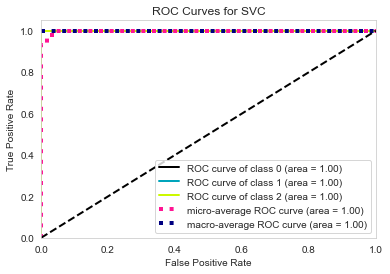

In [63]:
y_prob_test = grid_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_prob_test, title='ROC Curves for SVC')
plt.show()

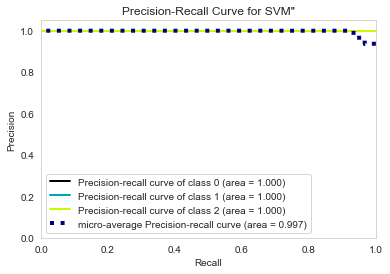

In [64]:
y_probas = grid_model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, title='Precision-Recall Curve for SVM"' )
plt.show()

In [65]:
out_score_svc = eval_metric_classification(
    grid_model, X_train, y_train, X_test, y_test, 
    'SVC', average='macro', labels=None
)
out_score_svc

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

# Random Forest Classifier

In [66]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


rfc_model = RandomForestClassifier()  
pipe_rfc = Pipeline([
        ("rfc", rfc_model),
]) 
pipe_rfc.fit(X_train , y_train)

Pipeline(steps=[('rfc', RandomForestClassifier())])

In [67]:
eval_metric(pipe_rfc, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 38  0]
 [ 0  0 40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        38
           2       1.00      1.00      1.00        40

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119



In [68]:
rfc_model = RandomForestClassifier(
    random_state=random_state
)  
model = Pipeline([
        ("rfc", rfc_model)
])

scoring = ['accuracy', 'f1_macro', 'precision_macro','recall_macro']
 
scores = cross_validate(
    model, X_train, y_train, 
    scoring = scoring, # ['accuracy', 'f1_macro', 'precision_macro','recall_macro'], 
    return_train_score=True,
    n_jobs=-1,
    cv=5,
)
df_scores = pd.DataFrame.from_dict(scores, orient='columns')
df_scores.mean()[2:]

test_accuracy           0.94964
train_accuracy          1.00000
test_f1_macro           0.94824
train_f1_macro          1.00000
test_precision_macro    0.95704
train_precision_macro   1.00000
test_recall_macro       0.94762
train_recall_macro      1.00000
dtype: float64

In [69]:
rfc_model = RandomForestClassifier(
       random_state=random_state)  
model = Pipeline([
     ("rfc", rfc_model)
])   
param_grid = {
    'rfc__max_depth': [3],
    'rfc__n_estimators': [50,70],
    'rfc__min_samples_leaf': [1,2],
    'rfc__criterion': ["entropy", "gini", "log_loss"],
    'rfc__max_features': ['sqrt', 'log2'],    
}

grid_model = GridSearchCV(
    estimator=model,
    param_grid = param_grid, 
    scoring = 'accuracy', 
   n_jobs=-1,
    cv=5
) 

In [70]:
%%time
grid_model.fit(X_train, y_train)

CPU times: user 553 ms, sys: 26.2 ms, total: 579 ms
Wall time: 1.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc',
                                        RandomForestClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'rfc__criterion': ['entropy', 'gini', 'log_loss'],
                         'rfc__max_depth': [3],
                         'rfc__max_features': ['sqrt', 'log2'],
                         'rfc__min_samples_leaf': [1, 2],
                         'rfc__n_estimators': [50, 70]},
             scoring='accuracy')

In [71]:
grid_model.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 3,
 'rfc__max_features': 'sqrt',
 'rfc__min_samples_leaf': 1,
 'rfc__n_estimators': 50}

In [72]:
grid_model.best_score_

0.9496376811594203

In [73]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[ 9  0  0]
 [ 0 12  0]
 [ 0  1  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[41  0  0]
 [ 0 36  2]
 [ 0  1 39]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       0.97      0.95      0.96        38
           2       0.95      0.97      0.96        40

    accuracy                           0.97       119
   macro avg       0.97      0.97      0.97       119
weighted avg       0.97      0.97      0.97       119



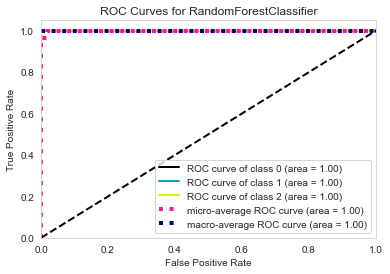

In [74]:
y_probas = grid_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas,title='ROC Curves for RandomForestClassifier' )
plt.show()

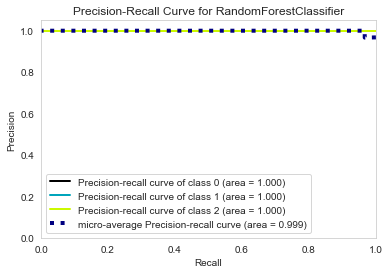

In [75]:
y_probas = grid_model.predict_proba(X_test)
skplt.metrics.plot_precision_recall(y_test, y_probas, title='Precision-Recall Curve for RandomForestClassifier' )
plt.show()

In [76]:
out_score_rfc = eval_metric_classification(
    grid_model, X_train, y_train, X_test, y_test, 
    'RFC', average='macro', labels=None
)
out_score_rfc

TEST REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.92      1.00      0.96        12
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30



AttributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'

In [77]:
compare = pd.concat([
    out_score_log, out_score_knn,
    out_score_svc, out_score_rfc
])
compare

NameError: name 'out_score_log' is not defined

In [78]:
compare = compare.sort_values(by='accuracy_test', ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='accuracy_test', y=compare.index, data=compare.round(3), palette="gnuplot")
ax.bar_label(ax.containers[0], fontsize=18, color='w', weight='bold', label_type='center', rotation=0)

plt.title("Test Accuracy Score of Different Models", size=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

NameError: name 'compare' is not defined

In [79]:
compare = compare.sort_values(by='f1_test', ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='f1_test', y=compare.index, data=compare.round(3), palette="tab20b_r")
ax.bar_label(ax.containers[0], fontsize=18, color='w', weight='bold', label_type='center', rotation=0)

plt.title("Test F1 Score of Different Models", size=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

NameError: name 'compare' is not defined

In [80]:
compare = compare.sort_values(by='recall_test', ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='recall_test', y=compare.index, data=compare.round(3), palette="plasma")
ax.bar_label(ax.containers[0], fontsize=18, color='w', weight='bold', label_type='center', rotation=0)

plt.title("Test Recall Score of Different Models", size=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

NameError: name 'compare' is not defined

In [81]:
compare = compare.sort_values(by='precision_test', ascending=False)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='precision_test', y=compare.index, data=compare.round(3), palette="gist_rainbow_r")
ax.bar_label(ax.containers[0], fontsize=18, color='w', weight='bold', label_type='center', rotation=0)

plt.title("Test Precision Score of Different Models", size=14)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.show()

NameError: name 'compare' is not defined

In [82]:
X = df.drop('species', axis=1)
y= df['species']

In [83]:
log_model = LogisticRegression(max_iter=5000, random_state= random_state)

model = Pipeline([ ('scaler', scaler)
                      ,('log', log_model)
                   ])


param_grid = {
    "log__penalty" : ['l1'],
    "log__C" : [16],
    "log__solver" : ['saga']
}

final_model = GridSearchCV(
    estimator = model,
    param_grid = param_grid, 
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
) 



In [84]:
final_model.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log',
                                        LogisticRegression(max_iter=5000,
                                                           random_state=101))]),
             n_jobs=-1,
             param_grid={'log__C': [16], 'log__penalty': ['l1'],
                         'log__solver': ['saga']},
             scoring='accuracy')

In [85]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,149.00000,5.84362,0.83085,4.30000,5.10000,5.80000,6.40000,7.90000
sepal_width,149.00000,3.05973,0.43634,2.00000,2.80000,3.00000,3.30000,4.40000
petal_length,149.00000,3.74899,1.76779,1.00000,1.60000,4.30000,5.10000,6.90000
petal_width,149.00000,1.19463,0.76262,0.10000,0.30000,1.30000,1.80000,2.50000


In [86]:
my_dict = {"sepal_length": [4.5, 5.8, 7.5],
           "sepal_width": [2.2, 3, 4.2],
           "petal_length": [1.3, 4.3, 6.5],
           "petal_width": [0.2, 1.3, 2.3]
          }

In [87]:
sample = pd.DataFrame(my_dict)
sample

,sepal_length,sepal_width,petal_length,petal_width
0,4.50000,2.20000,1.30000,0.20000
1,5.80000,3.00000,4.30000,1.30000
2,7.50000,4.20000,6.50000,2.30000


In [88]:
import pickle

In [89]:
pickle.dump(final_model, open('final_model_iris2','wb'))

In [90]:
dump(final_model, 'model/final_model_joblib')

['model/final_model_joblib']

In [91]:
final_model.predict(sample)

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [92]:
model = pickle.load(open('final_model_iris2','rb'))

In [93]:
model.predict(sample)

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [95]:
from joblib import load
model2 = load('model/final_model_joblib')

In [96]:
model2.predict(sample)

array(['setosa', 'versicolor', 'virginica'], dtype=object)